<a href="https://colab.research.google.com/github/Axel3D2Y/MACHINE-LEARNING-MODELS-USING-SCIKIT-LEARN/blob/main/Analisis%20NASA_Bearing_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NASA Bearing Dataset**

**Tareas:**


1. Análisis exploratorio de datos (EDA):

  * Visualiza las series temporales de los sensores para identificar patrones que ocurren antes de un fallo.
  * Realiza una correlación entre los valores de los sensores y la variable RUL para ver qué sensores son más relevantes.

2. Preparación de los datos:

  * Normaliza las lecturas de los sensores, ya que pueden tener escalas muy diferentes.
  * Crea una ventana de tiempo (sliding window) para entrenar un modelo con series temporales, es decir, utiliza las lecturas anteriores para predecir la vida útil restante.

3. Construcción del modelo:

  * Construir un modelo de regresión utilizando redes neuronales recurrentes (RNN) o LSTM (Long Short-Term Memory), que son adecuadas para series temporales.
  * Usa un conjunto de validación para ajustar el modelo y asegurarte de que no esté sobreajustado.

4. Optimización y evaluación del modelo:

  * Realiza una búsqueda de hiperparámetros (por ejemplo, número de capas, unidades LSTM, tasa de aprendizaje) utilizando GridSearchCV o técnicas de optimización como Bayesian Optimization.
  * Evalúa el rendimiento del modelo usando métricas como el RMSE (Root Mean Squared Error) o MAE (Mean Absolute Error).

# **Cargar los datos**

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [ ]:
index_names = ['numero de unidad', 'tiempo de ciclos'] #2 primeras columnas
setting_names = ['ajuste_1', 'ajuste_2', 'ajuste_3'] #columna de ajustes
sensor_names = ['sensor_{}'.format(i+1) for i in range(0,21)] #columna de los datos, se usaran para dividir a los datos con una separacion
col_names = index_names + setting_names + sensor_names #concatenar la fila de las caracteristas

In [ ]:
dftrain = pd.read_csv('/content/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv('/content/test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
y_valid = pd.read_csv('/content/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])

dftrain.shape, dfvalid.shape, y_valid.shape


((20631, 26), (13096, 26), (100, 1))

In [ ]:
train=dftrain.copy()
valid=dfvalid.copy()

# **Analisis exploratorio de los datos**

In [ ]:
#verificacion si hay datos nulos
print('Verificacion si hay datos nulos')
train.isnull().sum()

Verificacion si hay datos nulos


,0
numero de unidad,0
tiempo de ciclos,0
ajuste_1,0
ajuste_2,0
ajuste_3,0
sensor_1,0
sensor_2,0
sensor_3,0
sensor_4,0
sensor_5,0


In [ ]:
train.head(5)

,numero de unidad,tiempo de ciclos,ajuste_1,ajuste_2,ajuste_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [ ]:
# principales caracteristicas de las unidades, tiempo de ciclos,	ajuste_1,	ajuste_2,	ajuste_3(cantidad, media, des_estandar, min, primero, segundo y tercer cuartil, max )
train.loc[:,'numero de unidad':'ajuste_3'].describe()

,numero de unidad,tiempo de ciclos,ajuste_1,ajuste_2,ajuste_3
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0
std,29.227633,68.880990,0.002187,0.000293,0.0
min,1.000000,1.000000,-0.008700,-0.000600,100.0
25%,26.000000,52.000000,-0.001500,-0.000200,100.0
50%,52.000000,104.000000,0.000000,0.000000,100.0
75%,77.000000,156.000000,0.001500,0.000300,100.0
max,100.000000,362.000000,0.008700,0.000600,100.0


In [ ]:
# principales caracteristicas de cada uno de los sensores (cantidad, media, des_estandar, min, primero, segundo y tercer cuartil, max )
train.loc[:,'sensor_1':].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sensor_1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
sensor_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor_5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200
sensor_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
sensor_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
sensor_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
sensor_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
sensor_10,20631.0,1.300000,4.660829e-13,1.3000,1.3000,1.3000,1.3000,1.3000


# **Data visualization & Feature engineering**

In [ ]:
#De los datos los agrupamos por el numero de unidad y seleccionamos el valor maximo del tiempo de ciclos (Numero del ciclo en el que se encuentra)
max_tim_cycles = train.groupby('numero de unidad')['tiempo de ciclos'].max()
max_tim_cycles.head(3)

,tiempo de ciclos
numero de unidad,
1,192
2,287
3,179


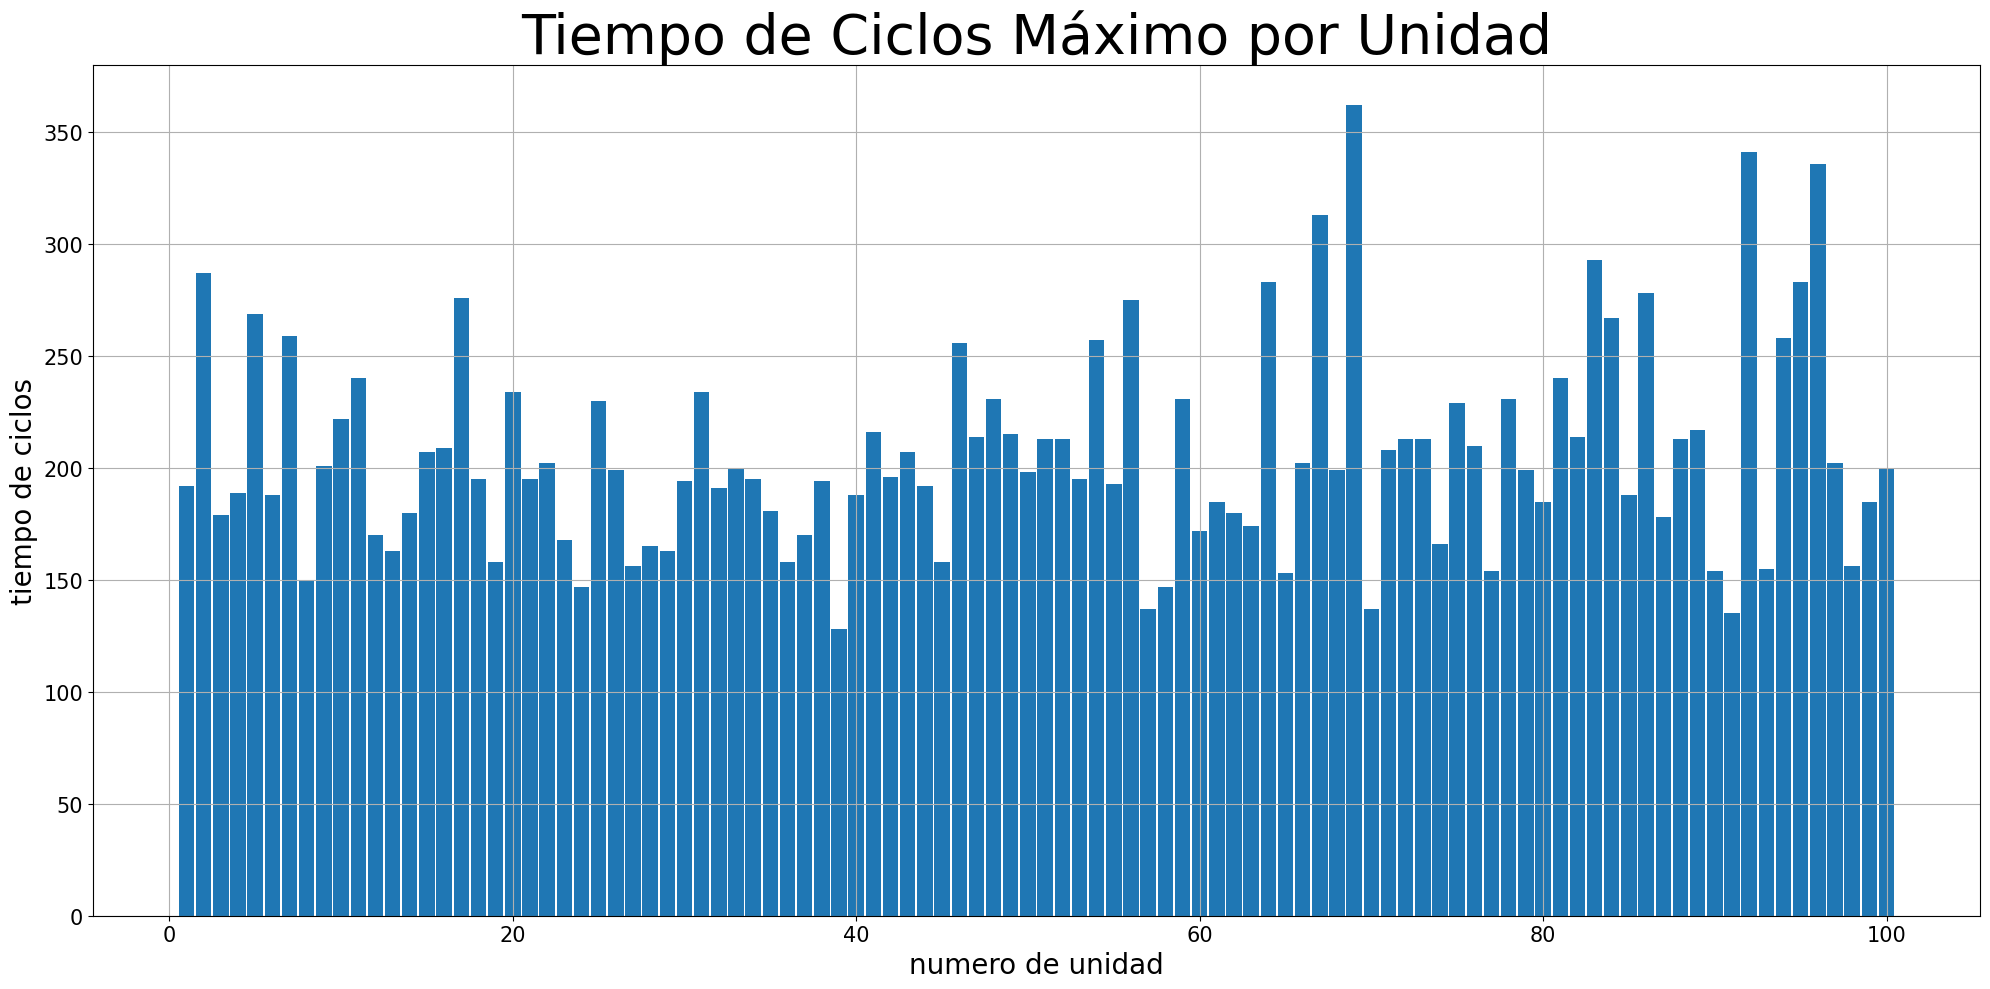

In [ ]:
plt.figure(figsize=(20, 10))
ax = plt.bar(max_tim_cycles.index, max_tim_cycles.values, width=0.9 ,bottom=None, align='center')
plt.xlabel('numero de unidad', size=20) # Add label for x-axis
plt.ylabel('tiempo de ciclos', size=20) # Add label for y-axis
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid(True)
plt.title('Tiempo de Ciclos Máximo por Unidad', size=40) # Add title
plt.tight_layout()
plt.show()

Text(0.5, 9.444444444444438, 'max time cycle')

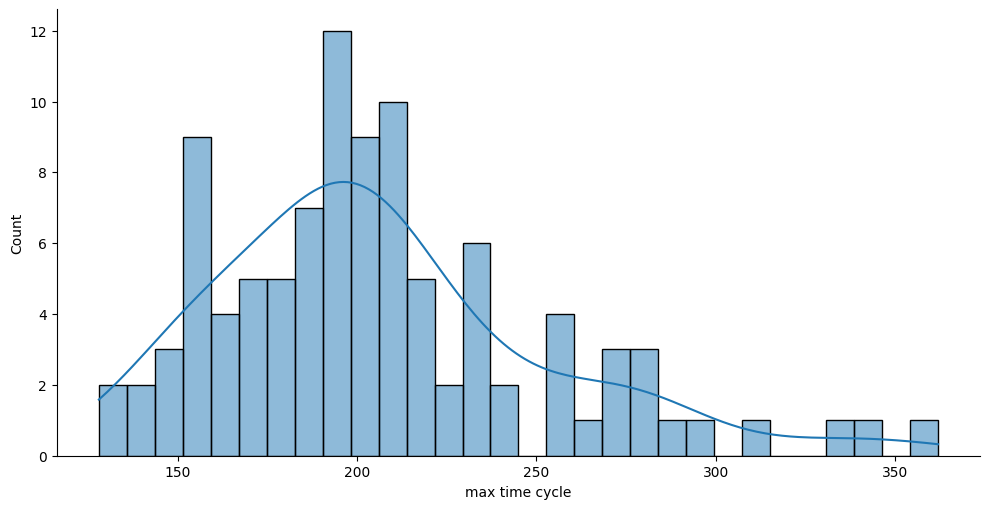

In [ ]:
#Distribucion del numero de ciclos
sns.displot(max_tim_cycles.values,kde=True,bins=30,height=5,aspect=2)
plt.xlabel('max time cycle')

In [ ]:
train.head(2)

,numero de unidad,tiempo de ciclos,ajuste_1,ajuste_2,ajuste_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236


In [ ]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='numero de unidad') #agrupamos el data frame de acuerdo al numero de unidades
    max_time_cycles = train_grouped_by_unit['tiempo de ciclos'].max() #obtenemos el maximo de ciclos de cada unidad
    merged = df.merge(max_time_cycles.to_frame(name='max_tim_cycle'), left_on='numero de unidad',right_index=True)
        #merge() combina el df de entrada a la funcion (data grame) original con el data frame max time cyvles
        # .to_frame convierte max_time_cicles en un data frame de una sola columna con el nombre 'max_tim_cycle'
        # right_index=True.  El índice del DataFrame max_time_cycles (que contiene los números de unidad) se utiliza para alinear correctamente los datos.
    merged["RUL"] = merged["max_tim_cycle"] - merged['tiempo de ciclos'] #se calcula el numero de ciclo restante  Remaining Useful Life (RUL) o Vida Útil Restante
    merged = merged.drop("max_tim_cycle", axis=1) # elimnamos la columna auxiliar
    return merged

In [ ]:
train = add_RUL_column(train)

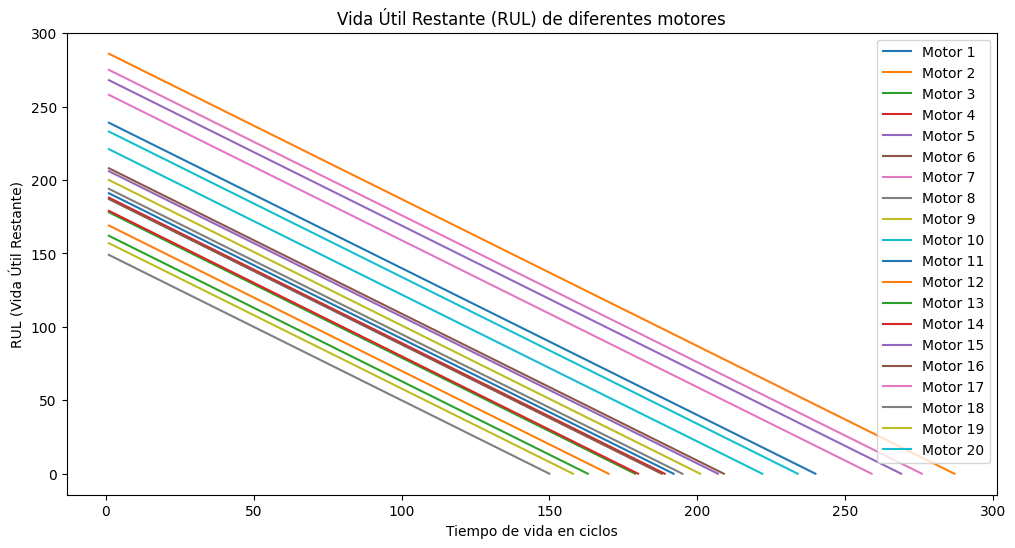

In [ ]:
sample_units = train['numero de unidad'].unique()[:20] #agrupamos por distintos numeros de unidad y obtenemos 20 motores

plt.figure(figsize=(12, 6))
for unit in sample_units:
    plt.plot(train[train['numero de unidad'] == unit]['tiempo de ciclos'], train[train['numero de unidad'] == unit]['RUL'], label=f'Motor {unit}')
    # de los datos, si el numero de motor es igual al numero de unidad seleccionada va a graficar con respecto a
plt.title('Vida Útil Restante (RUL) de diferentes motores')
plt.xlabel('Tiempo de vida en ciclos')
plt.ylabel('RUL (Vida Útil Restante)')
plt.legend()
plt.show()

# **Mapas de correlaciones**

In [ ]:
#Matriz de Correlaciones
correlacciones = train.corr()
correlacciones

,numero de unidad,tiempo de ciclos,ajuste_1,ajuste_2,ajuste_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
numero de unidad,1.000000,0.078753,-0.017895,-0.006197,NaN,NaN,0.014133,0.012621,0.026116,NaN,...,0.044230,-0.059473,0.022486,NaN,0.013513,NaN,NaN,-0.020589,-0.016465,0.078753
tiempo de ciclos,0.078753,1.000000,-0.004527,0.016132,NaN,NaN,0.549898,0.543947,0.624577,NaN,...,0.477523,0.370324,0.588676,NaN,0.566995,NaN,NaN,-0.583597,-0.585923,-0.736241
ajuste_1,-0.017895,-0.004527,1.000000,0.011660,NaN,NaN,0.009030,-0.005651,0.009544,NaN,...,0.002318,-0.004469,0.007652,NaN,0.002599,NaN,NaN,-0.005713,-0.014559,-0.003198
ajuste_2,-0.006197,0.016132,0.011660,1.000000,NaN,NaN,0.007266,0.009068,0.014673,NaN,...,0.018156,-0.006310,0.014156,NaN,0.012280,NaN,NaN,-0.010554,-0.007846,-0.001948
ajuste_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sensor_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sensor_2,0.014133,0.549898,0.009030,0.007266,NaN,NaN,1.000000,0.602610,0.714949,NaN,...,0.661792,0.179752,0.675975,NaN,0.629886,NaN,NaN,-0.661841,-0.668050,-0.606484
sensor_3,0.012621,0.543947,-0.005651,0.009068,NaN,NaN,0.602610,1.000000,0.678413,NaN,...,0.600963,0.237137,0.639921,NaN,0.600017,NaN,NaN,-0.625941,-0.633901,-0.584520
sensor_4,0.026116,0.624577,0.009544,0.014673,NaN,NaN,0.714949,0.678413,1.000000,NaN,...,0.745158,0.190748,0.758459,NaN,0.703499,NaN,NaN,-0.748067,-0.745193,-0.678948
sensor_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


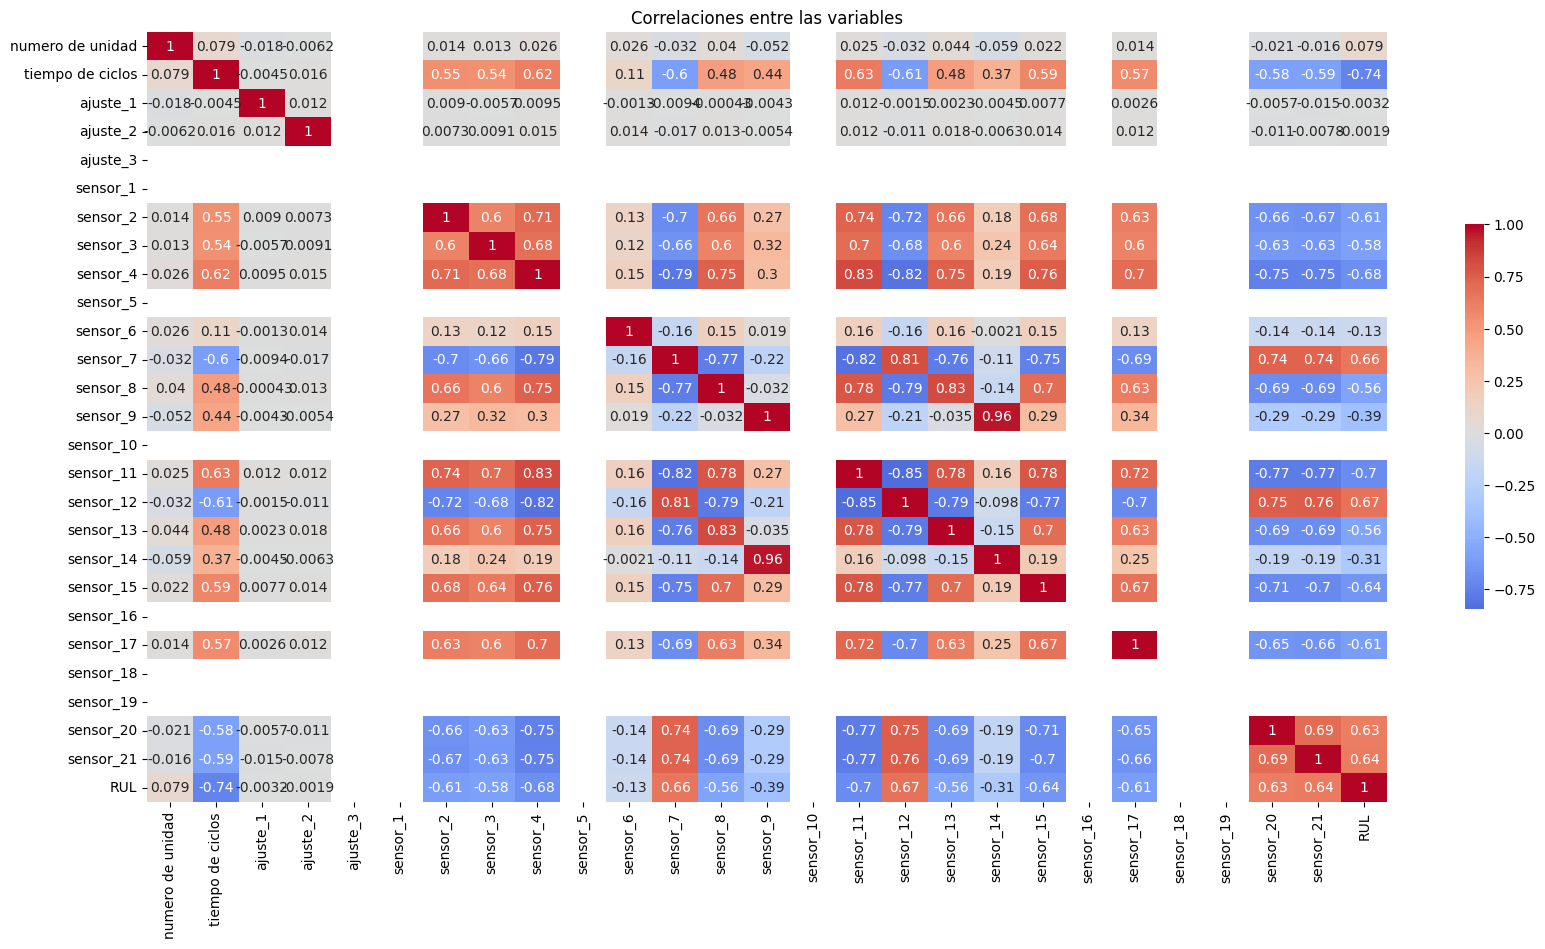

In [ ]:
#Mapa de color de las correlaciones entre las variables, los espacios en blanco corresponden a variables NaN
plt.figure(figsize=(20,10))
sns.heatmap(correlacciones,annot=True, cmap='coolwarm',center=0,cbar_kws={"shrink": 0.5})
plt.title('Correlaciones entre las variables')
plt.show()

Text(0.5, 1.0, 'Correlaciones entre las variables')

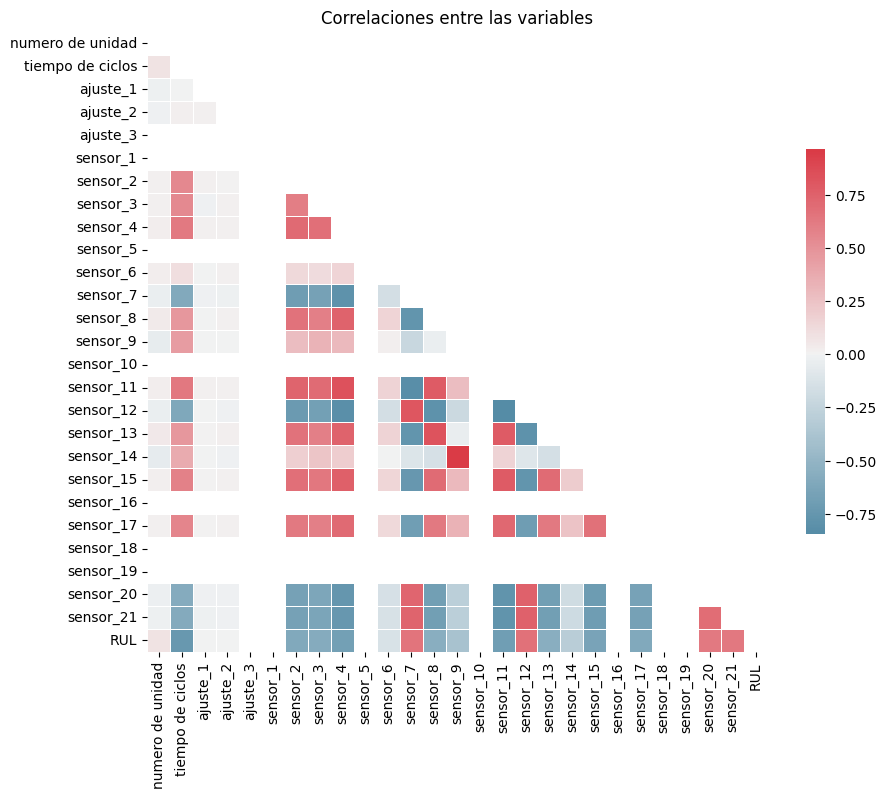

In [ ]:
#Mapa de color de las correlaciones entre las variables de manera triangular
mask = np.triu(np.ones_like(correlacciones, dtype=bool)) #genera una matriz de booleanos (True/False), luego solo considera la parte triangular
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True) #paleta de color
sns.heatmap(correlacciones, mask=mask, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}) #dibuja el mapa de calor
plt.title('Correlaciones entre las variables')


# **Resolucion del problema de redes lstm (Chatgtp)**

In [ ]:
# Selección de las columnas de sensores y la variable objetivo RUL
X=train.loc[:,'sensor_1':'sensor_21']
y=train.loc[:,'RUL']
X

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [ ]:
#Normalizar las caracteristicas de los sensores
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

In [ ]:
# Separar el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)

In [ ]:
X_train.shape

(16504, 21)

In [ ]:
# Re-dimensionar las entradas para el modelo LSTM: (n_samples, timesteps, n_features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# Construcción del modelo LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Salida: RUL

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 9558.3193 - val_loss: 1892.6256
Epoch 2/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 1859.3397 - val_loss: 1768.9697
Epoch 3/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1733.9983 - val_loss: 1751.9865
Epoch 4/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1777.0287 - val_loss: 1741.7429
Epoch 5/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1818.6237 - val_loss: 1767.3597
Epoch 6/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1760.6204 - val_loss: 1759.7178
Epoch 7/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1750.7548 - val_loss: 1742.5242
Epoch 8/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1749.5292 - val_loss: 1734.1946
Epoch 9/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1821.7665 - val_loss: 1729.8856
Epoch 10/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1781.0247 - val_loss: 1727.5073
Epoch 11/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1755.8129 - val_lo

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE: 29.39260411609135
RMSE: 41.31161638910813


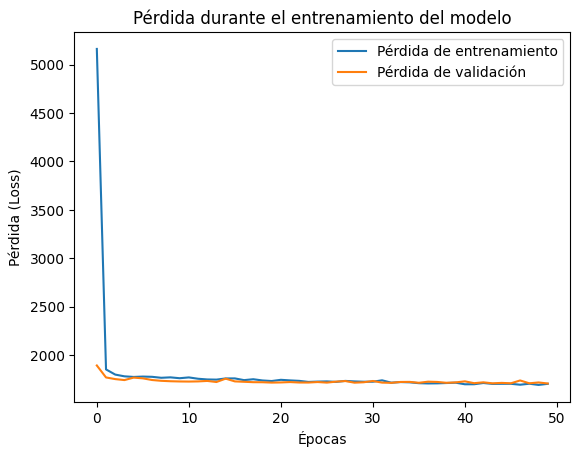

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicción en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el MAE y RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

# Graficar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Datos de prueba (ej: características de los sensores)
X_test = np.array([
    [200, 30, 0.5, 500, 0.02],
    [300, 45, 0.7, 400, 0.03],
    [100, 20, 0.3, 600, 0.01]
])

print("Datos de prueba (X_test):")
print(X_test)

Datos de prueba (X_test):
[[2.0e+02 3.0e+01 5.0e-01 5.0e+02 2.0e-02]
 [3.0e+02 4.5e+01 7.0e-01 4.0e+02 3.0e-02]
 [1.0e+02 2.0e+01 3.0e-01 6.0e+02 1.0e-02]]


# **Construccion de random forest**

In [ ]:
Diccionario_sensores={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]

i=1
for elemento in dict_list:
  Diccionario_sensores['Sensor_'+ str(i)]=elemento
  i+=1
Diccionario_sensores

{'Sensor_1': '(Fan inlet temperature) (◦R)',
 'Sensor_2': '(LPC outlet temperature) (◦R)',
 'Sensor_3': '(HPC outlet temperature) (◦R)',
 'Sensor_4': '(LPT outlet temperature) (◦R)',
 'Sensor_5': '(Fan inlet Pressure) (psia)',
 'Sensor_6': '(bypass-duct pressure) (psia)',
 'Sensor_7': '(HPC outlet pressure) (psia)',
 'Sensor_8': '(Physical fan speed) (rpm)',
 'Sensor_9': '(Physical core speed) (rpm)',
 'Sensor_10': '(Engine pressure ratio(P50/P2)',
 'Sensor_11': '(HPC outlet Static pressure) (psia)',
 'Sensor_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 'Sensor_13': '(Corrected fan speed) (rpm)',
 'Sensor_14': '(Corrected core speed) (rpm)',
 'Sensor_15': '(Bypass Ratio) ',
 'Sensor_16': '(Burner fuel-air ratio)',
 'Sensor_17': '(Bleed Enthalpy)',
 'Sensor_18': '(Required fan speed)',
 'Sensor_19': '(Required fan conversion speed)',
 'Sensor_20': '(High-pressure turbines Cool air flow)',
 'Sensor_21': '(Low-pressure turbines Cool air flow)'}

In [ ]:
def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if (i % 10 == 0):   #For a better visualisation, we plot the sensors signals of 20 units only
            plt.plot('RUL', signal_name, data=df[df['unit_number']==i])

    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()

In [ ]:
for i in range(1,22):
    try:
        plot_signal(train, Diccionario_sensores,'s_'+str(i))
    except:
        pass

<ipython-input-39-49b658b24b1f>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(13,5))


<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

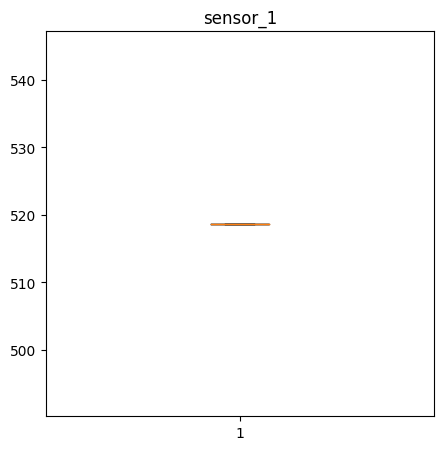

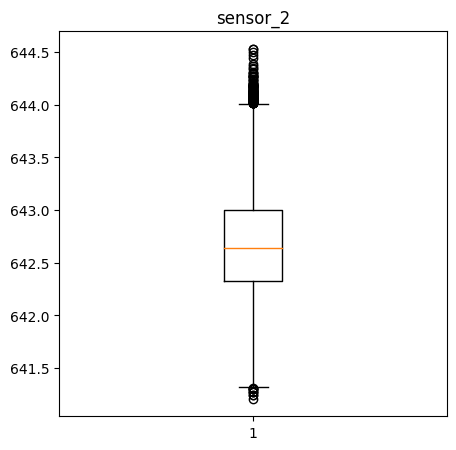

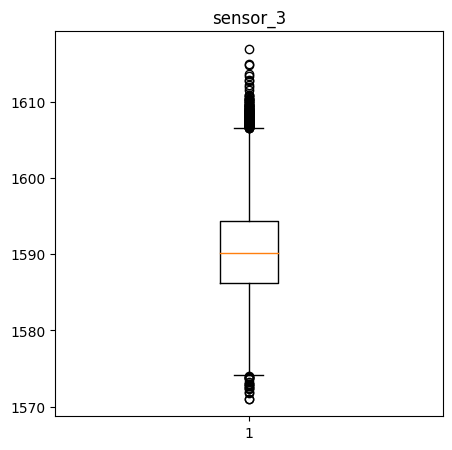

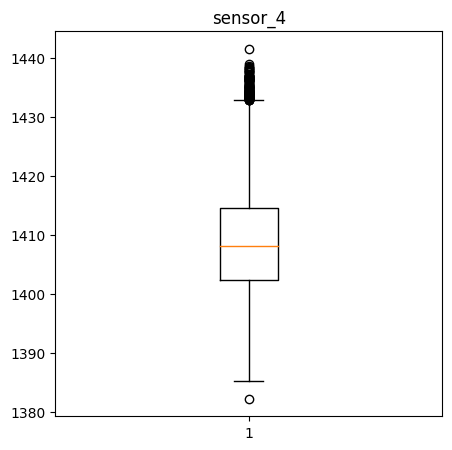

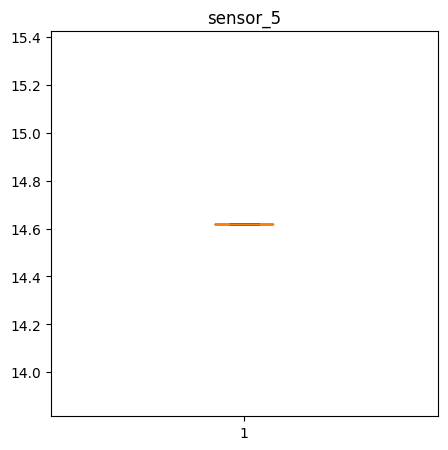

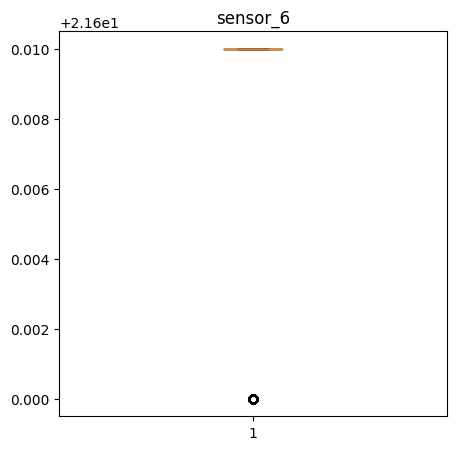

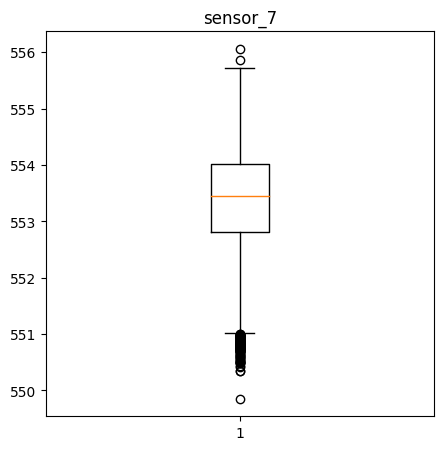

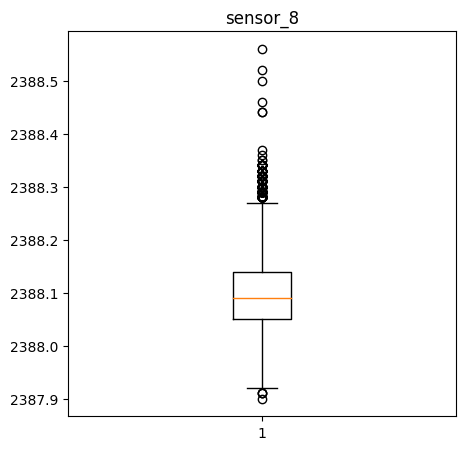

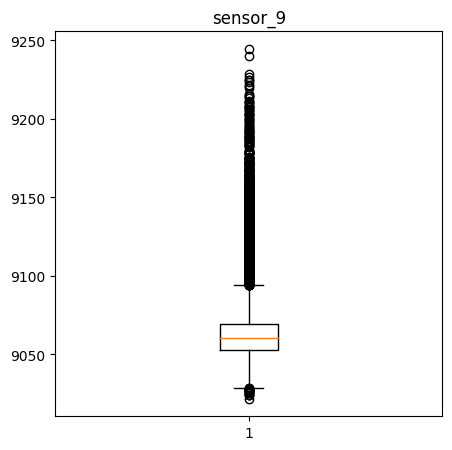

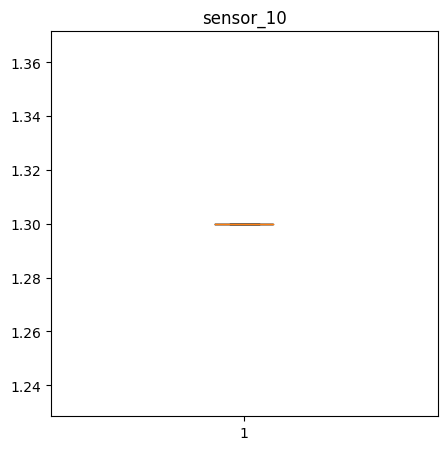

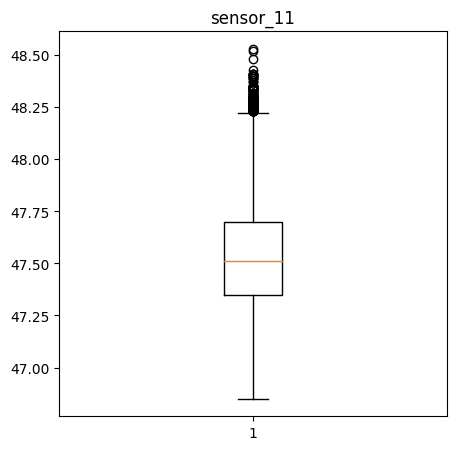

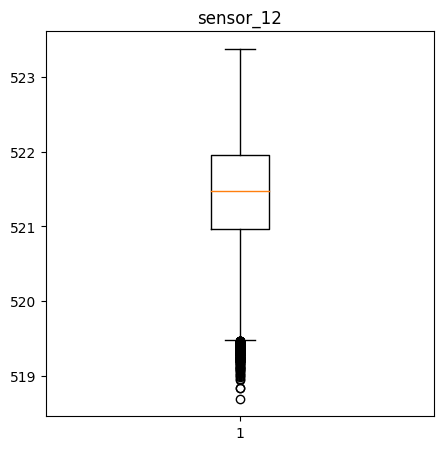

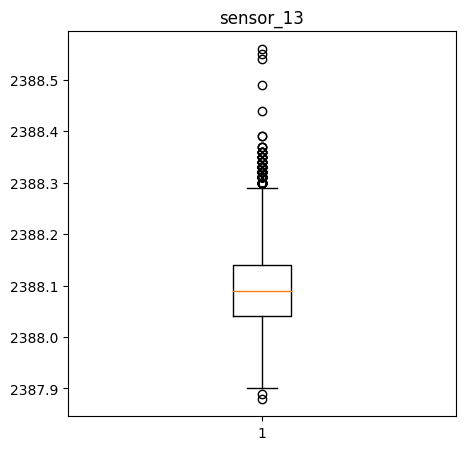

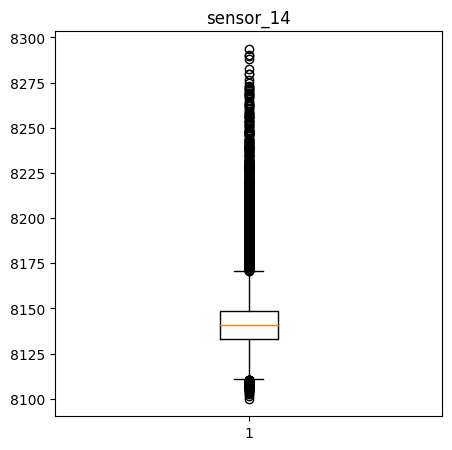

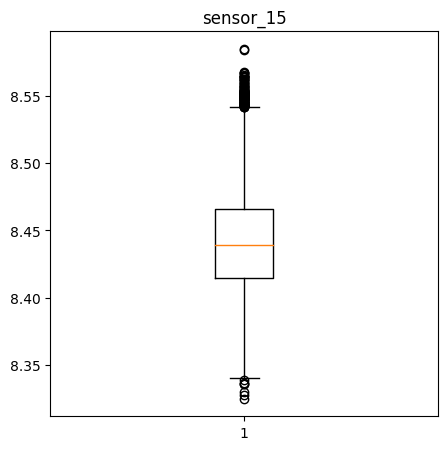

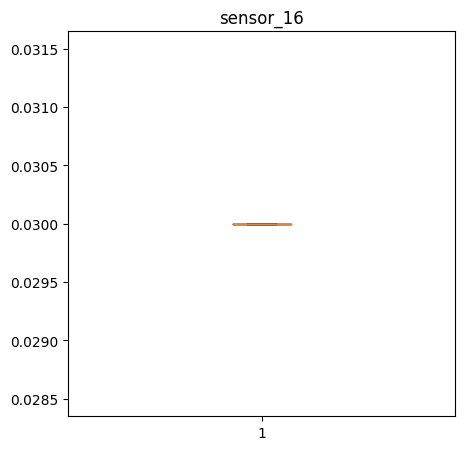

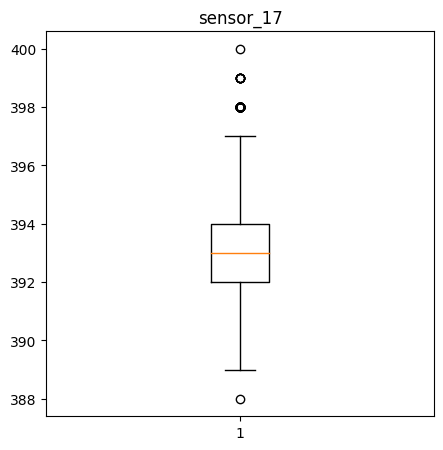

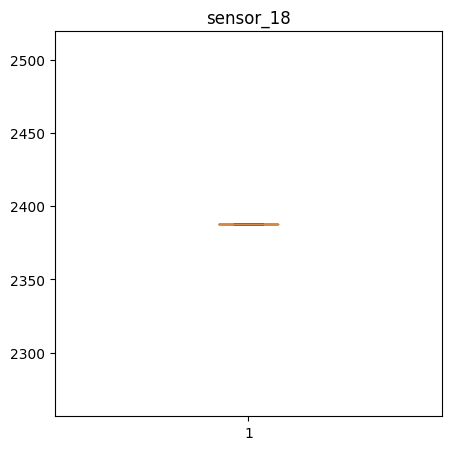

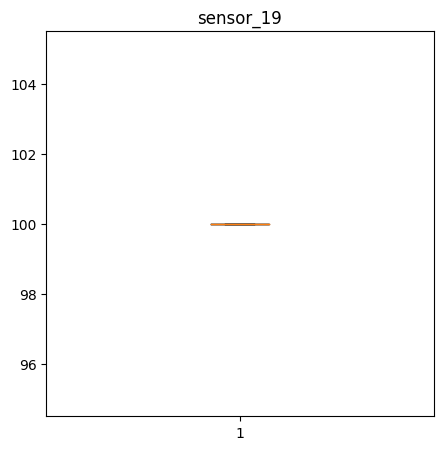

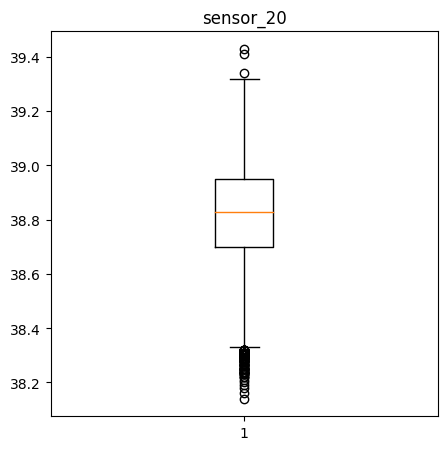

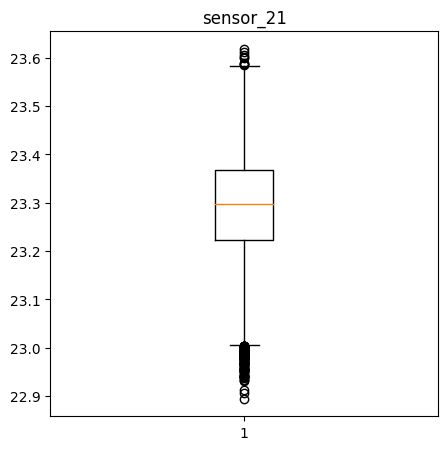

In [ ]:
for i in sensor_names:
  plt.figure(figsize=(5,5))
  plt.boxplot(train[i])
  plt.title(i)
  plt.show()

In [ ]:
train.loc[:, 'sensor_1': ].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sensor_1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
sensor_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor_5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200
sensor_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
sensor_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
sensor_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
sensor_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
sensor_10,20631.0,1.300000,4.660829e-13,1.3000,1.3000,1.3000,1.3000,1.3000
